In [27]:
from dataloader import DAVIS_Seq2, normalize_image, BallDataset
from model import Model
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import PIL.Image as Image
import numpy as np
from preprocess_utensils import get_gray_image, get_boundary_iou
import json

In [29]:
data_set = BallDataset()
# data_set = DAVIS_Seq2(is_one_video=True)

batch_size = 1
data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=True, num_workers=4)

In [30]:
pre_frame, curr_frame, pre_boundary, curr_boundary = next(iter(data_loader))

In [31]:
pre_frame.shape

torch.Size([1, 3, 224, 224])

Text(0.5, 1.0, 'Curr Frame')

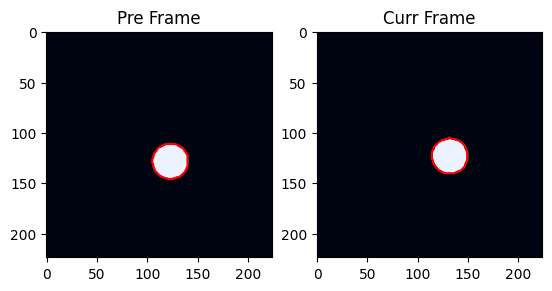

In [32]:
index = 0
plt.subplot(1, 2, 1)
plt.imshow(normalize_image(pre_frame[index].permute(1, 2, 0)))
plt.plot(pre_boundary[index][:, 0], pre_boundary[index][:, 1], 'r')
plt.title('Pre Frame')
plt.subplot(1, 2, 2)
plt.imshow(normalize_image(curr_frame[index].permute(1, 2, 0)))
plt.plot(curr_boundary[index][:, 0], curr_boundary[index][:, 1], 'r')
plt.title('Curr Frame')


In [33]:
model = Model()

In [34]:
def chamer_distance_loss(x, y):
    def my_chamfer_distance(x, y):
        x = x.unsqueeze(1)
        y = y.unsqueeze(0)
        dist = torch.sum((x - y) ** 2, dim=-1)
        dist1 = torch.min(dist, dim=1)[0]
        dist2 = torch.min(dist, dim=0)[0]
        return torch.mean(dist1) + torch.mean(dist2)

    result = torch.tensor(0.0).to(x.device)
    for i in range(x.shape[0]):
        result += my_chamfer_distance(x[i], y[i])

    return result / x.shape[0]

predict_boundary = pre_boundary.clone()
predict_boundary[:, :, 0] += 9
predict_boundary[:, :, 1] += -5
# print(curr_boundary - pre_boundary)
chamer_distance_loss(
    curr_boundary.float(),
    (predict_boundary).float()
)

tensor(0.9125)

In [35]:
pre_boundary.shape, curr_boundary.shape

(torch.Size([1, 80, 2]), torch.Size([1, 80, 2]))

In [36]:
def order_loss(x: torch.Tensor, y: torch.Tensor):
    def my_order_loss(x, y):
        min_loss = (x - y).abs().sum()
        for shift in range(1, x.shape[0]):
            # loss = (x - torch.roll(y, shifts=shift, dims=0)).pow(2).sum().sqrt()
            loss = (x - torch.roll(y, shifts=shift, dims=0)).abs().sum()
            min_loss = torch.min(min_loss, loss)
        return min_loss / x.shape[0]
        # return min_loss
        
    result = torch.tensor(0.0).to(x.device)
    for i in range(x.shape[0]):
        result += my_order_loss(x[i], y[i])

    return result / x.shape[0]
predict_boundary = pre_boundary.clone()
predict_boundary[:, :, 0] += 8
predict_boundary[:, :, 1] += -5
order_loss(curr_boundary, predict_boundary)

tensor(1.1750)

In [37]:
torch.cuda.empty_cache()

In [38]:
model = model.cuda()
output = model(pre_frame.to("cuda"), curr_frame.to("cuda"), pre_boundary.to("cuda")).cpu()
predic_boundary = output + pre_boundary
chamer_distance_loss(predic_boundary, curr_boundary.float())

tensor(96.3698, grad_fn=<DivBackward0>)

In [81]:
model = Model().to('cuda')
model_name = "uniform_model"
data_set = BallDataset()
# data_set = DAVIS_Seq2(is_uniform=True, is_one_video=True)
# loss_name = "chamer_distance_loss"
loss_name = "order_loss"
if loss_name == "chamer_distance_loss":
    loss_func = chamer_distance_loss
else:
    loss_func = order_loss
batch_size = 1
data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=True, num_workers=4)

In [82]:
torch.cuda.memory_allocated() / 1024 / 1024 / 1024

2.4353699684143066

In [83]:
dict_loss = {}
num_epochs = 100
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
gradient_clip = 2
min_loss = 1e10
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
for e in range(num_epochs):
    model.train()
    for pre_frame, curr_frame, pre_boundary, curr_boundary in tqdm(data_loader):
        pre_frame, curr_frame, pre_boundary, curr_boundary = (
            pre_frame.to("cuda"),
            curr_frame.to("cuda"),
            pre_boundary.to("cuda"),
            curr_boundary.to("cuda"),
        )
        optimizer.zero_grad()
        output = model(pre_frame, curr_frame, pre_boundary)
        predic_boundary = output + pre_boundary
        loss = loss_func(predic_boundary, curr_boundary.float())
        nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
        loss.backward()
        optimizer.step()
        if loss.item() < min_loss:
            min_loss = loss.item()
            torch.save(model.state_dict(), f"./models/{model_name}_{loss_name}.pth")
    dict_loss[e] = loss.item()
    scheduler.step()
    print(f"Epoch {e + 1}, Loss: {loss.item()}")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:38<00:00,  3.51s/it]


Epoch 1, Loss: 7.6262431144714355


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:34<00:00,  3.18s/it]


Epoch 2, Loss: 4.50683069229126


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:31<00:00,  2.87s/it]


Epoch 3, Loss: 2.0023446083068848


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:21<00:00,  1.94s/it]


Epoch 4, Loss: 1.144858717918396


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:07<00:00,  1.42it/s]


Epoch 5, Loss: 1.292990803718567


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:07<00:00,  1.43it/s]


Epoch 6, Loss: 0.8299179077148438


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:08<00:00,  1.37it/s]


Epoch 7, Loss: 1.0377053022384644


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:07<00:00,  1.42it/s]


Epoch 8, Loss: 1.203463077545166


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.51it/s]


Epoch 9, Loss: 1.153286337852478


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.53it/s]


Epoch 10, Loss: 0.9984847903251648


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.55it/s]


Epoch 11, Loss: 0.5507844090461731


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.32it/s]


Epoch 12, Loss: 0.6951128244400024


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:07<00:00,  1.40it/s]


Epoch 13, Loss: 1.0099495649337769


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.55it/s]


Epoch 14, Loss: 1.0035566091537476


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.34it/s]


Epoch 15, Loss: 0.8779599070549011


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.55it/s]


Epoch 16, Loss: 1.061062216758728


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.56it/s]


Epoch 17, Loss: 0.9706603288650513


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.28it/s]


Epoch 18, Loss: 0.5744094252586365


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.35it/s]


Epoch 19, Loss: 1.18793785572052


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.51it/s]


Epoch 20, Loss: 0.9775622487068176


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.43it/s]


Epoch 21, Loss: 1.0527220964431763


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.55it/s]


Epoch 22, Loss: 1.1163243055343628


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.04it/s]


Epoch 23, Loss: 0.6391602754592896


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.32it/s]


Epoch 24, Loss: 0.992515504360199


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.13it/s]


Epoch 25, Loss: 0.638522744178772


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.55it/s]


Epoch 26, Loss: 0.6204233169555664


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.66it/s]


Epoch 27, Loss: 0.9778180122375488


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.52it/s]


Epoch 28, Loss: 0.6592226028442383


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.85it/s]


Epoch 29, Loss: 0.6306564211845398


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.17it/s]


Epoch 30, Loss: 0.6143600344657898


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.59it/s]


Epoch 31, Loss: 0.7521086931228638


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.54it/s]


Epoch 32, Loss: 0.54656583070755


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.19it/s]


Epoch 33, Loss: 0.5398011207580566


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.30it/s]


Epoch 34, Loss: 1.0897456407546997


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.32it/s]


Epoch 35, Loss: 0.6246042251586914


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.43it/s]


Epoch 36, Loss: 0.5495590567588806


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.58it/s]


Epoch 37, Loss: 0.5391740202903748


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.10it/s]


Epoch 38, Loss: 1.0062769651412964


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.32it/s]


Epoch 39, Loss: 0.4786427617073059


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.49it/s]


Epoch 40, Loss: 0.6189038157463074


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.55it/s]


Epoch 41, Loss: 1.0017145872116089


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.01it/s]


Epoch 42, Loss: 0.7633359432220459


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.29it/s]


Epoch 43, Loss: 1.0912699699401855


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.50it/s]


Epoch 44, Loss: 0.760388195514679


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.43it/s]


Epoch 45, Loss: 0.4804407060146332


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.01it/s]


Epoch 46, Loss: 1.0924626588821411


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.68it/s]


Epoch 47, Loss: 0.48455238342285156


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.46it/s]


Epoch 48, Loss: 0.5330306887626648


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.83it/s]


Epoch 49, Loss: 0.5579302906990051


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.29it/s]


Epoch 50, Loss: 0.5439319014549255


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.95it/s]


Epoch 51, Loss: 1.0325757265090942


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.52it/s]


Epoch 52, Loss: 0.5232003331184387


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.47it/s]


Epoch 53, Loss: 0.5139447450637817


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.43it/s]


Epoch 54, Loss: 1.014825463294983


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00, 10.99it/s]


Epoch 55, Loss: 1.0174487829208374


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.27it/s]


Epoch 56, Loss: 0.9244880080223083


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.28it/s]


Epoch 57, Loss: 0.6107821464538574


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.43it/s]


Epoch 58, Loss: 0.5251709222793579


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.20it/s]


Epoch 59, Loss: 0.813980221748352


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.78it/s]


Epoch 60, Loss: 0.7905667424201965


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.47it/s]


Epoch 61, Loss: 0.4888514578342438


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.11it/s]


Epoch 62, Loss: 0.6150266528129578


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.37it/s]


Epoch 63, Loss: 0.8196128010749817


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.48it/s]


Epoch 64, Loss: 0.9993637204170227


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.38it/s]


Epoch 65, Loss: 0.513443648815155


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.12it/s]


Epoch 66, Loss: 0.4575459659099579


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.44it/s]


Epoch 67, Loss: 0.7909883856773376


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.41it/s]


Epoch 68, Loss: 1.0713509321212769


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.38it/s]


Epoch 69, Loss: 0.9370781183242798


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.53it/s]


Epoch 70, Loss: 0.9141079783439636


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.25it/s]


Epoch 71, Loss: 0.7810103297233582


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.61it/s]


Epoch 72, Loss: 0.6183133125305176


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.56it/s]


Epoch 73, Loss: 0.8146039843559265


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.38it/s]


Epoch 74, Loss: 0.48186132311820984


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.40it/s]


Epoch 75, Loss: 0.7849116325378418


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.22it/s]


Epoch 76, Loss: 1.1035845279693604


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.75it/s]


Epoch 77, Loss: 0.4634077250957489


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.63it/s]


Epoch 78, Loss: 0.9839408993721008


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.56it/s]


Epoch 79, Loss: 0.5594264268875122


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.25it/s]


Epoch 80, Loss: 0.9519683718681335


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.53it/s]


Epoch 81, Loss: 0.9964072108268738


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.29it/s]


Epoch 82, Loss: 0.5487932562828064


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.58it/s]


Epoch 83, Loss: 0.9799186587333679


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.30it/s]


Epoch 84, Loss: 0.9184759259223938


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.55it/s]


Epoch 85, Loss: 1.0143953561782837


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.65it/s]


Epoch 86, Loss: 0.8051161766052246


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.48it/s]


Epoch 87, Loss: 0.8030673265457153


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.29it/s]


Epoch 88, Loss: 0.7464302778244019


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.86it/s]


Epoch 89, Loss: 0.7904903888702393


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.43it/s]


Epoch 90, Loss: 0.7857140302658081


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.36it/s]


Epoch 91, Loss: 1.104361891746521


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00, 10.97it/s]


Epoch 92, Loss: 0.6347076296806335


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.14it/s]


Epoch 93, Loss: 1.0854519605636597


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.12it/s]


Epoch 94, Loss: 0.8061563372612


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.06it/s]


Epoch 95, Loss: 1.0265169143676758


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.38it/s]


Epoch 96, Loss: 0.49047690629959106


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.21it/s]


Epoch 97, Loss: 1.1117597818374634


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.30it/s]


Epoch 98, Loss: 0.7911807298660278


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.96it/s]


Epoch 99, Loss: 0.7801997065544128


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 12.11it/s]

Epoch 100, Loss: 0.7653691172599792


In [95]:
# save loss
with open(f"./log/{model_name}_{loss_name}.json", "w") as f:
    json.dump(dict_loss, f)

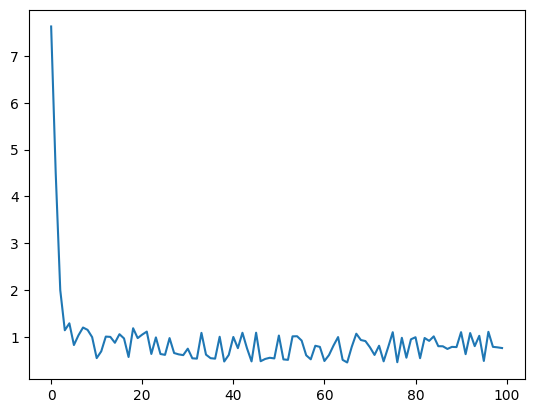

In [84]:
# plot the loss
plt.plot(list(dict_loss.keys()), list(dict_loss.values()))

In [53]:
model = Model()
model_name = "uniform_model"
# model_name = "simplify_model"
loss_name = "order_loss"
# loss_name = "chamer_distance_loss"
model.load_state_dict(torch.load(f"./models/{model_name}_{loss_name}.pth"))
model = model.to("cuda")

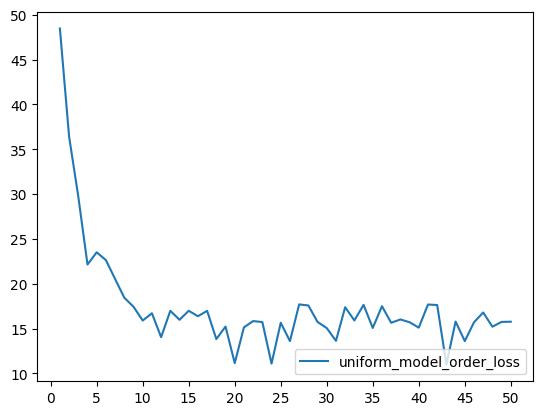

In [52]:
# load the loss
with open(f"./log/{model_name}_{loss_name}.json", "r") as f:
    dict_loss = json.load(f)
# plot the loss
plt.plot(np.array(list(dict_loss.keys())).astype(int) + 1, list(dict_loss.values()), label=f"{model_name}_{loss_name}")
plt.legend(loc="lower right")
# set the xticks
plt.xticks(np.arange(0, 51, 5))
plt.show()

In [43]:
class DAVIS_test(torch.utils.data.Dataset):
    def __init__(self, video_name: str, is_uniform=True):
        self.transform = transforms.Compose(
            [
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ]
        )
        if is_uniform:
            with open("./uniform_samples_80.json", "r") as f:
                tmp_data: dict[str, list[tuple[str, str, list]]] = json.loads(f.read())
        else:
            with open("./simplify_samples_80.json", "r") as f:
                tmp_data: dict[str, list[tuple[str, str, list]]] = json.loads(f.read())
        
        self.data = tmp_data[video_name]
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, sgm_path, boundary = self.data[idx]
        img = Image.open(img_path)
        sgm = get_gray_image(sgm_path)
        img = self.transform(img)
        boundary = np.array(boundary).astype(np.int32)
        boundary = torch.tensor(boundary).int()
        return img, sgm, boundary

In [72]:
class Balltest(torch.utils.data.Dataset):
    def __init__(self, json_path="./ball/uniform_samples_80.json"):
        self.json_path = json_path
        self.transform = transforms.Compose(
            [
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )
        self.data = json.load(open(json_path, "r"))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, boundary = self.data[idx]
        img = Image.open(img_path).convert("RGB")
        img = self.transform(img)
        sgm = get_gray_image(img_path)
        boundary = np.array(boundary).astype(np.int32)
        boundary = torch.tensor(boundary).int()
        return img, sgm, boundary

  0%|                                                                                                                       | 0/11 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 24.25it/s]


0.7005523555273202

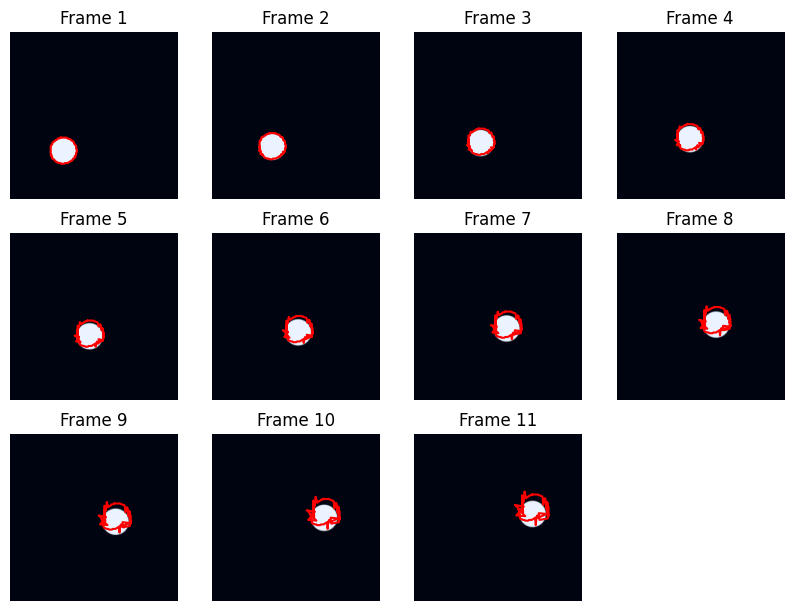

In [85]:
def test_model_one_video(model, test_dataset: torch.utils.data.Dataset, device="cuda"):
    pre_img, pre_sgm, pre_boundary = test_dataset[0]
    plt.figure(figsize=(10, 10))
    # plt.subplot(4, 4, 1)
    # plt.imshow(normalize_image(pre_img.permute(1, 2, 0)))
    # plt.plot(pre_boundary[:, 0], pre_boundary[:, 1], 'r')
    # plt.axis('off')
    # plt.title('Frame 0')
    pre_boundary = pre_boundary.to(device)
    total_iou = 0
    model.eval()
    interval = 1
    for i in tqdm(range(1, len(test_dataset))):
        img, sgm, boundary = test_dataset[i]
        # print(pre_img.shape, img.shape, pre_boundary.shape)
        with torch.no_grad():
            boundary_offset = model(
                pre_img.unsqueeze(0).to(device),
                img.unsqueeze(0).to(device),
                pre_boundary.unsqueeze(0).to(device),
            )
            # pre_boundary[:, 0] += 9
            # print(boundary_offset)
            pre_boundary = pre_boundary + boundary_offset.squeeze(0)
            pre_boundary = pre_boundary.int()
            pre_boundary = torch.clamp(pre_boundary, 0, 223)
            # print(pre_boundary.cpu() - boundary)
            # pre_boundary = boundary.squeeze(0).to(device)
            pre_img = img
            if i % interval == 0:
                # plt.subplot(4, 4, i // interval + 1)
                plt.subplot(4, 4, i // interval)
                plt.imshow(normalize_image(pre_img.permute(1, 2, 0)))
                # index = 10
                # plt.scatter(pre_boundary.cpu().numpy()[:, 0][index], pre_boundary.cpu().numpy()[:, 1][index], )
                plt.plot(pre_boundary.cpu().numpy()[:, 0], pre_boundary.cpu().numpy()[:, 1], "r")
                plt.axis('off')
                plt.title(f'Frame {i}')
        total_iou += get_boundary_iou(sgm, pre_boundary.cpu().numpy())
    return total_iou / (len(test_dataset) - 1)
# if model_name == "uniform_model":
#     test_dataset = DAVIS_test("bear", is_uniform=True)
# else:
#     test_dataset = DAVIS_test("bear", is_uniform=False)
test_dataset = Balltest()
test_model_one_video(model, test_dataset)